In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [83]:
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [84]:
df=pd.read_csv("Fraud.csv")

### Visualizing Transaction Types
Creating a bar chart to show the distribution of different transaction types in the dataset. This helps in understanding which types of transactions are most common.

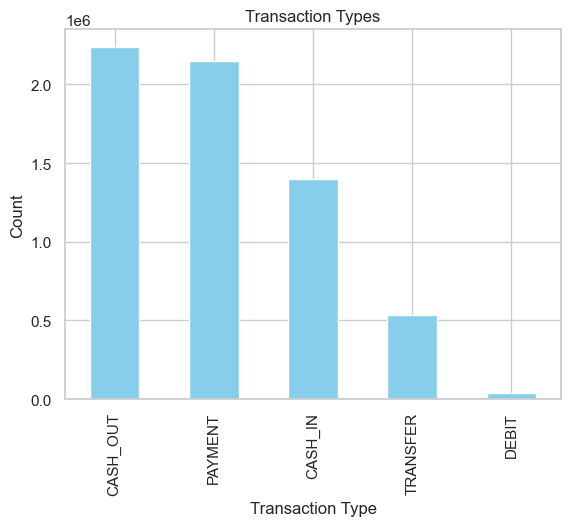

In [85]:
df["type"].value_counts().plot(kind="bar", color="skyblue")
plt.title("Transaction Types")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.show()

### Analyzing Fraud Rate by Transaction Type
Calculating and plotting the fraud rate for each transaction type. This is a crucial step to identify which transaction types are most susceptible to fraud.

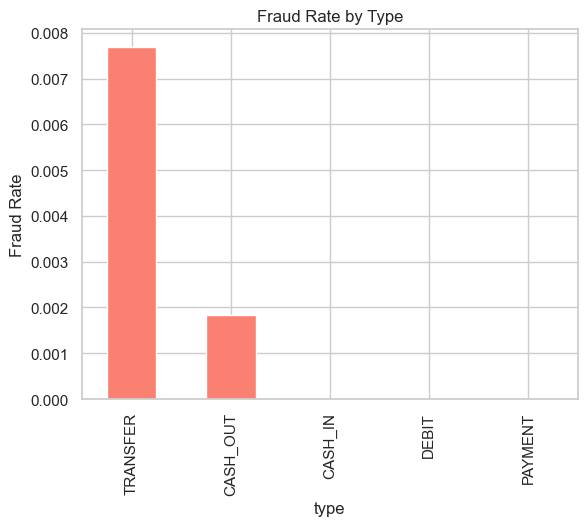

In [86]:
fraud_by_type=df.groupby("type")["isFraud"].mean().sort_values(ascending=False)
fraud_by_type.plot(kind="bar", title="Fraud Rate by Type", color="salmon")
plt.ylabel("Fraud Rate")
plt.show()

### Distribution of Transaction Amounts
Creating a histogram to visualize the distribution of transaction amounts. A logarithmic scale is used to handle the wide range of transaction values and provide a clearer view of the distribution.

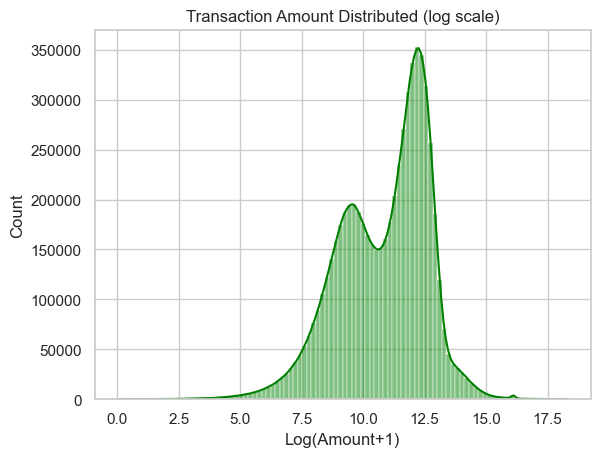

In [87]:
sns.histplot(np.log1p(df["amount"]), bins=100, kde=True, color="green")
plt.title("Transaction Amount Distributed (log scale)")
plt.xlabel("Log(Amount+1)")
plt.show()

### Amount vs. Fraud
Creating a box plot to compare the transaction amounts for fraudulent and non-fraudulent transactions. To make the plot more readable, it's filtered to show only transactions with amounts less than 50,000.

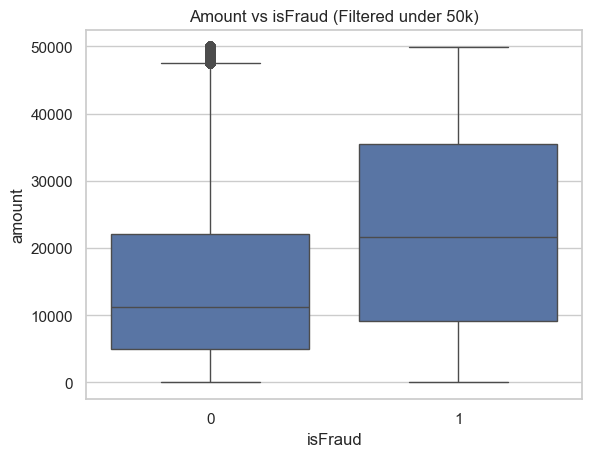

In [88]:
sns.boxplot(data=df[df["amount"]<50000], x="isFraud", y="amount")
plt.title("Amount vs isFraud (Filtered under 50k)")
plt.show()

## Feature Engineering
Creating two new features: `balanceDiffOrig` and `balanceDiffDest`. These features represent the change in balance for the sender and receiver, which could be important indicators of fraudulent activity.

In [89]:
df["balanceDiffOrig"]=df["oldbalanceOrg"]-df["newbalanceOrig"]
df["balanceDiffDest"]=df["newbalanceDest"]-df["oldbalanceDest"]

### Frauds Over Time
Plotting the number of fraudulent transactions over time (represented by the 'step' column). This helps in identifying any temporal patterns in fraudulent activities.

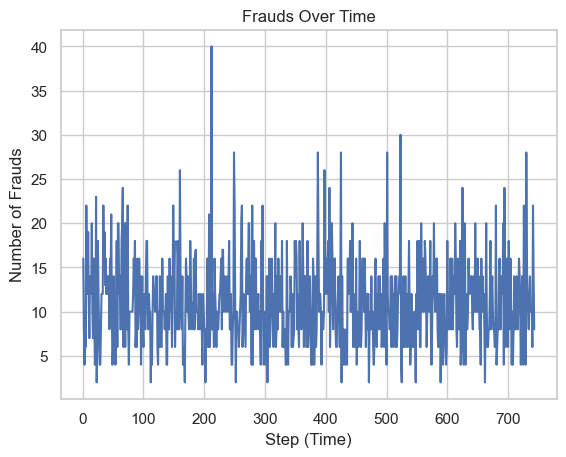

In [90]:
frauds_per_step=df[df["isFraud"]==1]["step"].value_counts().sort_index()
plt.plot(frauds_per_step.index, frauds_per_step.values, label="Frauds per Step")
plt.xlabel("Step (Time)")
plt.ylabel("Number of Frauds")
plt.title("Frauds Over Time")
plt.grid(True)
plt.show()

#### Dropping the 'step' Column
The 'step' column, which represents time, is dropped from the DataFrame as it will not be used in the final model.

In [91]:
df.drop(columns="step",inplace=True)

#### Identifying Top Senders and Receivers
Identifying the top 10 senders and receivers by transaction frequency. This can help in anomaly detection and understanding transaction patterns.

In [92]:
top_senders=df["nameOrig"].value_counts().head(10)

In [93]:
top_receivers=df["nameDest"].value_counts().head(10)

#### Identifying Top Fraudulent Users
Identifying the top 10 users who have initiated the most fraudulent transactions.

In [94]:
fraud_users=df[df["isFraud"]==1]["nameOrig"].value_counts().head(10)

### Filtering by Fraudulent Transaction Types
Filtering the DataFrame to include only 'TRANSFER' and 'CASH_OUT' transaction types, as these are the types where fraud is most prevalent.

In [95]:
fraud_types=df[df["type"].isin(["TRANSFER", "CASH_OUT"])]

### Visualizing Fraud Distribution
Creating a count plot to show the distribution of fraudulent vs. non-fraudulent transactions within the filtered 'TRANSFER' and 'CASH_OUT' types.

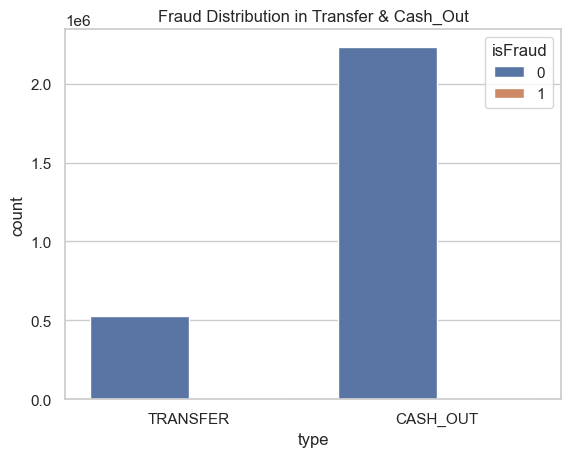

In [96]:
sns.countplot(data=fraud_types, x="type", hue="isFraud")
plt.title("Fraud Distribution in Transfer & Cash_Out")
plt.show()

### Correlation Matrix
Calculating the correlation between the numerical features and the 'isFraud' target variable.

In [97]:
corr=df[["amount","oldbalanceOrg","newbalanceOrig", "oldbalanceDest", "newbalanceDest", "isFraud"]].corr()

### Visualizing the Correlation Matrix
Creating a heatmap to visualize the correlation matrix. This provides a clear and intuitive way to understand the relationships between different features.

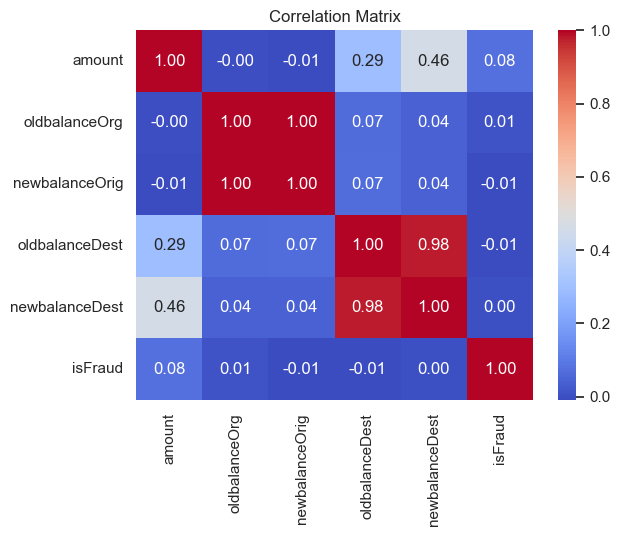

In [98]:
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### Analyzing Transactions with Zero Balance
Filtering for transactions where the sender's balance becomes zero after a 'TRANSFER' or 'CASH_OUT'. This is a common pattern in fraudulent transactions.

In [99]:
zero_after_transfer=df[
    (df["oldbalanceOrg"]>0) &
    (df["newbalanceOrig"]==0) &
    (df["type"].isin(["TRANSFER", "CASH_OUT"]))
]

## Importing Machine Learning Libraries

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

##### Dropping the 'nameOrig', 'nameDest', and 'isFlaggedFraud' columns, which are not needed for the model.

In [101]:
df_model=df.drop(["nameOrig","nameDest","isFlaggedFraud"], axis=1)

##### Defining Categorical and Numeric Features

In [102]:
categorical=["type"]
numeric=["amount", "oldbalanceOrg","newbalanceOrig", "newbalanceDest"]

##### Splitting the Data into features (X) and the target variable (y)

In [103]:
y=df_model["isFraud"]
X=df_model.drop("isFraud", axis=1)

### Train-Test Split
The model will be trained on the training set and evaluated on the testing set. `stratify=y` ensures that the proportion of fraudulent and non-fraudulent transactions is the same in both the train and test sets.

In [104]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, stratify=y)

### Creating a Preprocessing Pipeline
Creating a `ColumnTransformer` to apply different preprocessing steps to the numeric and categorical features.
- **StandardScaler:** Scales the numeric features to have a mean of 0 and a standard deviation of 1.
- **OneHotEncoder:** Converts the categorical features into a numerical format.

In [105]:
preprocessor=ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric),
        ("cat", OneHotEncoder(drop="first"), categorical)
    ],
    remainder="drop"
)

### Creating the Final Model Pipeline
Creating a scikit-learn pipeline that combines the preprocessing steps with a `LogisticRegression` classifier. `class_weight="balanced"` is used to handle the class imbalance in the dataset.

In [106]:
pipeline=Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(class_weight="balanced", max_iter=1000))
     ])

## Training the Model

In [107]:
pipeline.fit(X_train, y_train)

,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Making Predictions

In [108]:
y_pred=pipeline.predict(X_test)

### Evaluating the Model
A classification report includes precision, recall, and F1-score for each class. This provides a detailed evaluation of the model's performance.

In [109]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97   1906322
           1       0.02      0.92      0.04      2464

    accuracy                           0.94   1908786
   macro avg       0.51      0.93      0.51   1908786
weighted avg       1.00      0.94      0.97   1908786



### Confusion Matrix
A confusion matrix gives a more detailed breakdown of the model's predictions.

In [110]:
confusion_matrix(y_test, y_pred)

array([[1799485,  106837],
       [    187,    2277]])

#### Model Accuracy

In [111]:
pipeline.score(X_test, y_test)

0.9439308544802822

In [112]:
import joblib
joblib.dump(pipeline, "fraud_detection_pipeline.pkl")

['fraud_detection_pipeline.pkl']